## **ITCS 3162 - Project 1**
#### Collecting and exploring 5,000 Steam reviews of Starfield
This dataset is comprised of 5,000 Steam user reviews of the game Starfield. The data will be analyzed to determine the differences between positive and negative reviews. These differences will be measured using the data associated with each review, which can be found on the <a href="https://partner.steamgames.com/doc/store/getreviews">Steamworks Documentation</a>. By default, the Steamworks API filters "off-topic" reviews that are a result of review bombing.

Using this data, I aimed to answer the question: What are the different characteristics of positive and negative Steam reviews?

In [74]:
#!pip install numpy pandas matplotlib seaborn
#!pip install wordcloud

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## Collecting Data

#### *Data Scraping Functions*
Based on <a href="https://andrew-muller.medium.com/scraping-steam-user-reviews-9a43f9e38c92">this guide by Andrew Muller</a>,
I scraped 5,000 of the most recent Steam reviews for the game Starfield. I selected the game Starfield because it is a recent, high-profile game with a good balance of positive and negative reviews. However, this code can scrape any number of reviews from any game on Steam by inputting the AppID into the get_n_reviews(appid, n) function. This function will return a JSON file of all n reviews and their fields. The fields of each review can be found on the <a href="https://partner.steamgames.com/doc/store/getreviews">Steamworks Documentation</a>.

In [76]:
# Reference - https://andrew-muller.medium.com/scraping-steam-user-reviews-9a43f9e38c92

# The following gathers the most recent reviews that follow certain criteria
import json
import requests

def get_reviews(appid, params={'json':1}):
        # Unique page for every Steam app that displays review data in .json format
        url = 'https://store.steampowered.com/appreviews/'
        response = requests.get(url=url+str(appid), params=params, headers={'User-Agent': 'Mozilla/5.0'})
        return response.json()

# Gets specified number of the most recent reviews
def get_n_reviews(appid, n):
    reviews = []
    cursor = '*' # Can gather more than 20 reviews at once
    params = { # More info - https://partner.steamgames.com/doc/store/getreviews
            'json' : 1,
            'filter' : 'recent', # sorted by recency
            'language' : 'english',
            'day_range' : 365, # Posted between now and specified day_range
            'review_type' : 'all', # Both positive and negative reviews
            'purchase_type' : 'steam' # Reviews by users who purchased the game and didn't receive it for free
            }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

        if len(response['reviews']) < 100: break

    return reviews

#### *Calling Scraping Functions, Saving the Data*

In [77]:
datapath = "./data"

dataset_size = 5000 # number of reviews
dataset = get_n_reviews(1716740, dataset_size) # the number is the game's Steam AppID.

with open(datapath+"/reviews.json", 'w') as f:
    json.dump(dataset, f)

df_raw = pd.read_json(datapath+"/reviews.json")
df = pd.concat([df_raw.drop(['author'],axis=1),df_raw['author'].apply(pd.Series)],axis=1)
df.to_csv(datapath+"/reviews.csv")

In [78]:
df.head()

recommendationid language  \
0         157539077  english   
1         157538663  english   
2         157538332  english   
3         157538026  english   
4         157536594  english   

                                              review   timestamp_created  \
0                                            fun ngl 2024-02-04 01:47:15   
1  This game had the potential to be the Mass Eff... 2024-02-04 01:38:48   
2  I really wanted to like this game, and I tried... 2024-02-04 01:32:10   
3  To fully realize how identity politics is ruin... 2024-02-04 01:25:27   
4  Great game, only issue is not being able to re... 2024-02-04 00:55:54   

    timestamp_updated  voted_up  votes_up  votes_funny  weighted_vote_score  \
0 2024-02-04 01:47:15      True         0            0             0.000000   
1 2024-02-04 01:38:48     False         5            0             0.480315   
2 2024-02-04 01:32:10     False         4            0             0.504132   
3 2024-02-04 01:25:27      True         2            0             0.472441   
4 2024-02-04 00:55:54      True         1            0             0.495868   

   comment_count  ...  written_during_early_access  hidden_in_steam_china  \
0              0  ...                        False                   True   
1              0  ...                        False                   True   
2              0  ...                        False                   True   
3              0  ...                        False                   True   
4              0  ...                        False                   True   

   steam_china_location            steamid num_games_owned num_reviews  \
0                        76561198098133552             239           9   
1                        76561198059931881             254          15   
2                        76561198024086348             818           9   
3                        76561198012847787               0           4   
4                        76561198036775121               0           9   

   playtime_forever  playtime_last_two_weeks  playtime_at_review  last_played  
0             12670                     2071               12466   1707045280  
1              3265                        0                3265   1697985516  
2              4194                        0                4194   1699838411  
3              1797                     1797                1467   1707089914  
4              1983                     1978                1653   1707088896  

[5 rows x 22 columns]

## Cleaning Data
At this point, the data cleaning process had already begun in the data collection phase. When scraping the data, I was able to set multiple parameters through Steamworks. For example, I had excluded any non-English reviews and reviews from people who had received the game for free. The rest of the data cleaning process was fairly trivial because of this. Since Steamworks autogenerates the metadata for each review, the data was well-structured and free of null values. Furthermore, I flattened subfields into their own column when converting the JSON to a CSV for easier parsing.
<br><br>
To finish the cleaning process, I dropped any fields that were redundant, such as the "language" field, or irrelevant, such as the reviewer's SteamID. I was able to narrow down the number of fields from 22 to 7.

In [79]:
# People with private game libraries will display as 0 games owned which doesn't represent reality
df_clean = df.drop(["num_games_owned"], axis=1)

# The data collection code only collects reviews from people who did not reveive the game for free,
# meaning this column only consists of false values and is therefore redundant.
df_clean = df_clean.drop(["received_for_free"], axis=1)

df_clean = df_clean.drop(["recommendationid"], axis=1)
df_clean = df_clean.drop(["steamid"], axis=1)
df_clean = df_clean.drop(["timestamp_created"], axis=1) 
df_clean = df_clean.drop(["timestamp_updated"], axis=1)
df_clean = df_clean.drop(["steam_purchase"], axis=1)
df_clean = df_clean.drop(["written_during_early_access"], axis=1) # Starfield did not have a public early access
df_clean = df_clean.drop(["hidden_in_steam_china"], axis=1)
df_clean = df_clean.drop(["steam_china_location"], axis=1)
df_clean = df_clean.drop(["last_played"], axis=1)
df_clean = df_clean.drop(["playtime_last_two_weeks"], axis=1)
df_clean = df_clean.drop(["comment_count"], axis=1)
df_clean = df_clean.drop(["playtime_forever"], axis=1)

df_clean = df_clean.drop(df_clean[df_clean["language"] != "english"].index) # removes non-english reviews (none in this case)

df_clean = df_clean.drop(["language"], axis=1)

In [80]:
df_clean.head()

review  voted_up  votes_up  \
0                                            fun ngl      True         0   
1  This game had the potential to be the Mass Eff...     False         5   
2  I really wanted to like this game, and I tried...     False         4   
3  To fully realize how identity politics is ruin...      True         2   
4  Great game, only issue is not being able to re...      True         1   

   votes_funny  weighted_vote_score  num_reviews  playtime_at_review  
0            0             0.000000            9               12466  
1            0             0.480315           15                3265  
2            0             0.504132            9                4194  
3            0             0.472441            4                1467  
4            0             0.495868            9                1653

## Data Exploration
I used boxplots, scatterplots, and word clouds to visualize and derive patterns from the data. I categorized the data visualizations into three groups: interaction data, author data, and review data.

Each review has the following fields:<br>
"voted_up", where True indicates a positive review and False indicates a negative review;<br>
"votes_up", indicating the number of users who like the review;<br>
"weighted_vote_score", which represents the user-rated "helpfulness" of the review on a weighted scale;<br>
"num_reviews", indicating the number of reviews that the author has written (with game per review);<br>
"playtime_at_review", indicating the number of minutes the author had spent in Starfield at the time the review was posted.



#### *Interaction Data*
This category includes fields that represent how other users interacted with each review. In this category, I compared "votes_up" and "weighted_vote_score" to whether a review was positive or negative.

In [81]:
dfg = df_clean.groupby(df_clean["voted_up"])

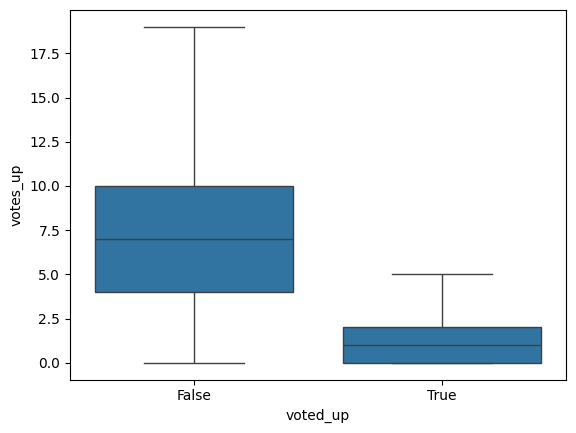

In [87]:
fig = sns.boxplot(x="voted_up", y="votes_up", data=df_clean, showfliers=False)

In [86]:
fig = sns.boxplot(x="voted_up", y="weighted_vote_score", data=df_clean, showfliers=False)

In [85]:
scatter = sns.scatterplot(data=df_clean, x='votes_up', y='weighted_vote_score', hue='voted_up')
scatter.set_xlim(left=0, right=100) # excludes extremes
plt.show()

#### *Author Data*
This category includes fields that represent the author of each review. In this category, I compared "num_reviews" and "playtime_at_review" to whether a review is positive or negative.

In [89]:
sns.boxplot(x="voted_up", y="num_reviews", data=df_clean, showfliers=False)

<Axes: xlabel='voted_up', ylabel='num_reviews'>

In [90]:
sns.boxplot(x="voted_up", y="playtime_at_review", data=df_clean, showfliers=False)

<Axes: xlabel='voted_up', ylabel='playtime_at_review'>

#### *Review Data*
This category is comprised of the words in each review. I compared the most used words in negative reviews to most used words in positive reviews.

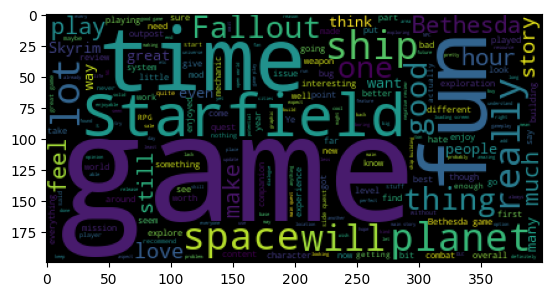

In [91]:
reviews = ''

for i in range(len(df_clean)):
    if df_clean["voted_up"][i] == True:
        reviews += df_clean['review'][i]

wc = WordCloud().generate(reviews)
plt.imshow(wc)

In [92]:
reviews = ''

for i in range(len(df_clean)):
    if df_clean["voted_up"][i] == False:
        reviews += df_clean['review'][i]

wc = WordCloud().generate(reviews)
plt.imshow(wc)

## Data Analysis

#### *Interaction Data*
The interaction data visualizations show that negative reviews are generally more interacted with than positive reviews. Both the median weighted_vote_score and number of votes_up are higher in negative reviews. This speaks to Starfields' mixed-to-negative reception from the Steam audience. However the difference in median weighted_vote_score is much smaller between positive and negative reviews than the median number of votes_up. Negative reviews appear to get far more votes_up than positive reviews. The scatterplot also shows this difference, illustrating that positive reviews are more likely to receive a higher weighted_vote_score than a high number of votes_up.

#### *Author Data*
The author data visualizations show that reviewers who post negative reviews are more likely to have posted reviews from many other games. This could illustrate that people who are more critical of a game's quality are more likely to speak up about their experience.

This data also reveals that, as expected, reviewers who reviewed Starfield positively played more of the game at the time of review.

#### *Review Data*
The words in the positive review word cloud that stuck out to me were "story", "combat", "weapon", and "explore". These could indicate what reviewers most enjoyed about the game. However, I also noticed the word "issue" was present in the word cloud. This may reveal that reviewers were willing to acknowledge some of the game's shortcomings while still praising its strengths.

Some of the more interesting words in the negative review word cloud include "loading screen", "Bethesda game", "Fallout", and "Skyrim". The first phrase, "loading screen", seems to be alluding to a common critique of Starfield's frequent use of loading screens to transition between sections of the game. It seems that this use of loading screens is a common issue for detractors of the game. The other three phrases, "Bethesda game", "Fallout", and "Skyrim" refer to the game's developer and their previous successful IPs. It seems that negative reviewers could be comparing Starfield to some of Bethesda's more well-recieved games such as The Elder Scrolls V: Skyrim and some of the games from the Fallout series.